<a href="https://colab.research.google.com/github/torikuri/transcriptions/blob/main/nussl_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial library installation

In [1]:
!pip install nussl

     |████████████████████████████████| 239 kB 8.2 MB/s 
     |████████████████████████████████| 51 kB 46 kB/s 
     |████████████████████████████████| 153 kB 45.4 MB/s 
     |████████████████████████████████| 251 kB 43.3 MB/s 
     |████████████████████████████████| 3.3 MB 42.7 MB/s 
     |████████████████████████████████| 310 kB 50.5 MB/s 
     |████████████████████████████████| 90 kB 10.5 MB/s 
     |████████████████████████████████| 963 kB 48.7 MB/s 
     |████████████████████████████████| 130 kB 53.4 MB/s 
     |████████████████████████████████| 6.2 MB 31.9 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4712 sha256=cdbec45e3d3c9eb65483a97bc5a3030a7fe86d61ad958f8fca9d6403185e3f0c
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=408d35f006495d3204cfffde298539b42a9b058a477a30789c7f2c70f74c1c98
  Stored in 

In [4]:
!pip install sox

In [5]:
import nussl
import matplotlib.pyplot as plt
import numpy as np
import time
start_time = time.time()

# loading and looking at basic information about the sound file

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving rhcp_soul_to_squeeze.wav to rhcp_soul_to_squeeze.wav
User uploaded file "rhcp_soul_to_squeeze.wav" with length 4722288 bytes


In [7]:
signal1 = nussl.AudioSignal("/content/rhcp_soul_to_squeeze.wav")

In [8]:
signal1.embed_audio()
print(signal1)

AudioSignal (unlabeled): 26.769 sec @ /content/rhcp_soul_to_squeeze.wav, 44100 Hz, 2 ch.


In [19]:
# STFT parameters
nussl.constants.ALL_WINDOWS

['hamming', 'rectangular', 'hann', 'blackman', 'triang', 'sqrt_hann']

In [20]:
stft = signal1.stft()
print(stft.shape)
# number of FFT bins
# length of the signal (in hops)
# number of channels

(129, 9224, 2)


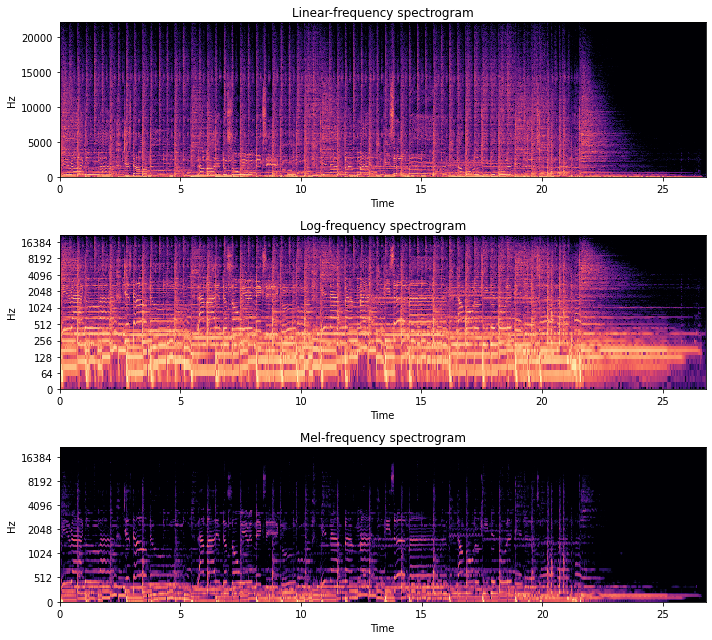

In [10]:


plt.figure(figsize=(10, 9))
plt.subplot(311)
plt.title('Linear-frequency spectrogram')
nussl.utils.visualize_spectrogram(signal1)

plt.subplot(312)
plt.title('Log-frequency spectrogram')
nussl.utils.visualize_spectrogram(signal1, y_axis='log')

plt.subplot(313)
plt.title('Mel-frequency spectrogram')
nussl.utils.visualize_spectrogram(signal1, y_axis='mel')

plt.tight_layout()
plt.show()

## apply a filter

In [11]:

# apply a filter, isolating frequencies below 1000Hz
lp_stft = signal1.stft_data.copy()
lp_cutoff = 1000  # Hz
frequency_vector = signal1.freq_vector  # a vector of frequency values for each FFT bin
idx = (np.abs(frequency_vector - lp_cutoff)).argmin()  # trick to find the index of the closest value to lp_cutoff
lp_stft[idx:, :, :] = 0.0j  # every freq above lp_cutoff is 0 now

In [12]:
signal1_lp = signal1.make_copy_with_stft_data(lp_stft)
print('Audio Data:', signal1_lp.audio_data)

Audio Data: None


In [13]:
signal1_lp.istft()
signal1_lp.embed_audio()
print(signal1_lp)

AudioSignal (unlabeled): 26.769 sec @ /content/rhcp_soul_to_squeeze.wav, 44100 Hz, 2 ch.


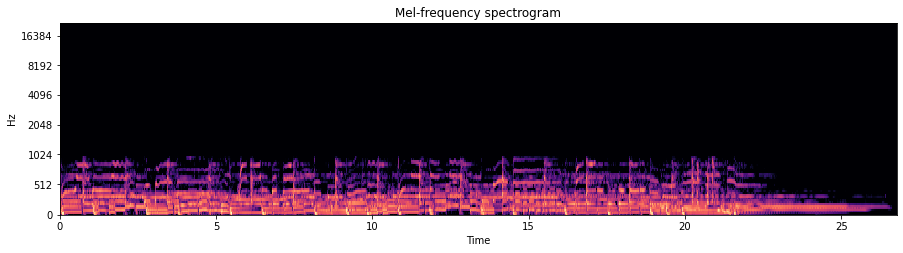

In [15]:
plt.figure(figsize=(15, 12))
plt.subplot(311)
plt.title('Mel-frequency spectrogram')
nussl.utils.visualize_spectrogram(signal1_lp, y_axis='mel')

# Running REPET
The beginnings of sound sepparation. REPET analyzes the sound file, figures out the size of the windows to be analysed, and creates a forground and background separation.

REPET is a masking technize, analyzing the sound waves directly to interpret. REEPT is great for isolating one voice that stands out from a repeating background, like a trumpet solo playing over a vamp for example.

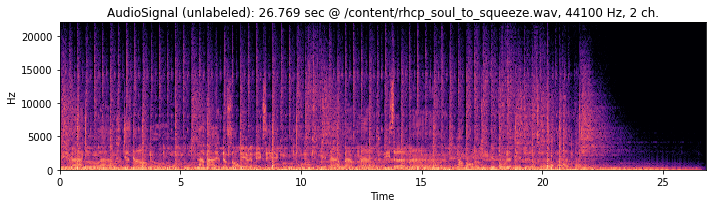

In [22]:
plt.figure(figsize=(10,3))
nussl.utils.visualize_spectrogram(signal1)
plt.title(str(signal1))
plt.tight_layout()
plt.show()

In [23]:
# the following method will guess the repeating period for us, if we know the exact period, or a rough idea, we could 
# call it out directly
repet = nussl.separation.primitive.Repet(signal1)

In [26]:
estimates = repet() # does run, then make_audio_signals

In [25]:
# see the guessed repeating periods
repet.repeating_period

923

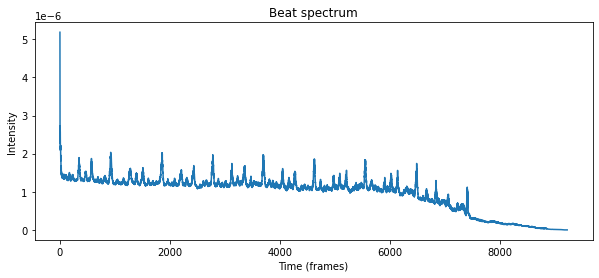

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(repet.beat_spectrum)
plt.xlabel('Time (frames)')
plt.ylabel('Intensity')
plt.title('Beat spectrum')
plt.show()

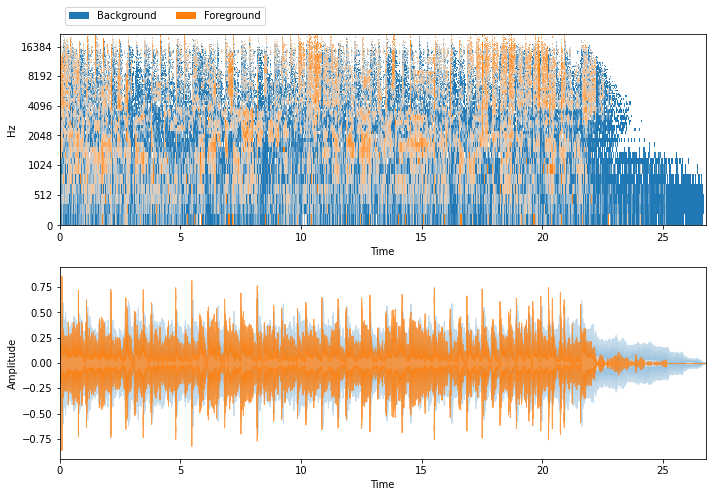


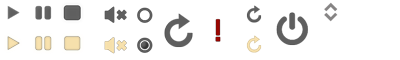
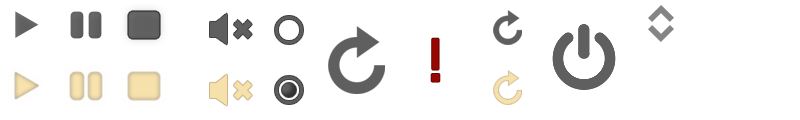
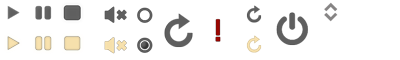

In [28]:
_estimates = {
    'Background': estimates[0],
    'Foreground': estimates[1]
} # organize estimates into a dict

plt.figure(figsize=(10, 7))
plt.subplot(211)
nussl.utils.visualize_sources_as_masks(
    _estimates, db_cutoff=-60, y_axis='mel')
plt.subplot(212)

# visnaulize as a waveform, built in nussl function
nussl.utils.visualize_sources_as_waveform(
    _estimates, show_legend=False)
plt.tight_layout()
plt.show()

nussl.play_utils.multitrack(_estimates)

## REPETSIM
this is a variation, but does not rely on repitition as explicitly as RETET does. It instead calculates a similiarity matrix between each pair of spectral frames in an STFT, selects the k nearest neighbor for each frame, makes a mask by median filtering the bins for each of the selected neighbors.

In [31]:
repet_sim = nussl.separation.primitive.RepetSim(signal1)
rsim_bg, rsim_fg = repet_sim()

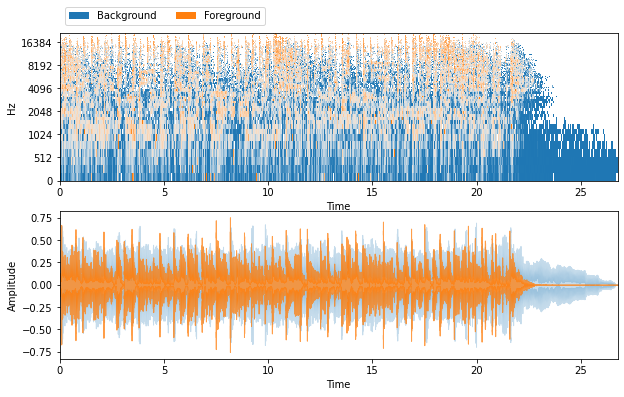

In [32]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
nussl.utils.visualize_sources_as_masks({
    'Background': rsim_bg, 'Foreground': rsim_fg},
    y_axis='mel', db_cutoff=-60, alpha_amount=2.0)

plt.subplot(212)
nussl.utils.visualize_sources_as_waveform({
    'Background': rsim_bg, 'Foreground': rsim_fg},
    show_legend=False)
plt.show()


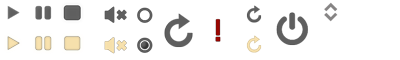
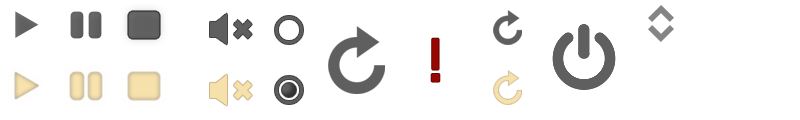
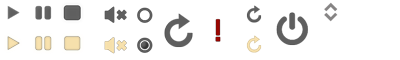

In [34]:
nussl.play_utils.multitrack(repet_sim(), ['Background', 'Foreground'])

## 2DFT

In [35]:
ft2d = nussl.separation.primitive.FT2D(signal1)
ft2d_bg, ft2d_fg = ft2d()

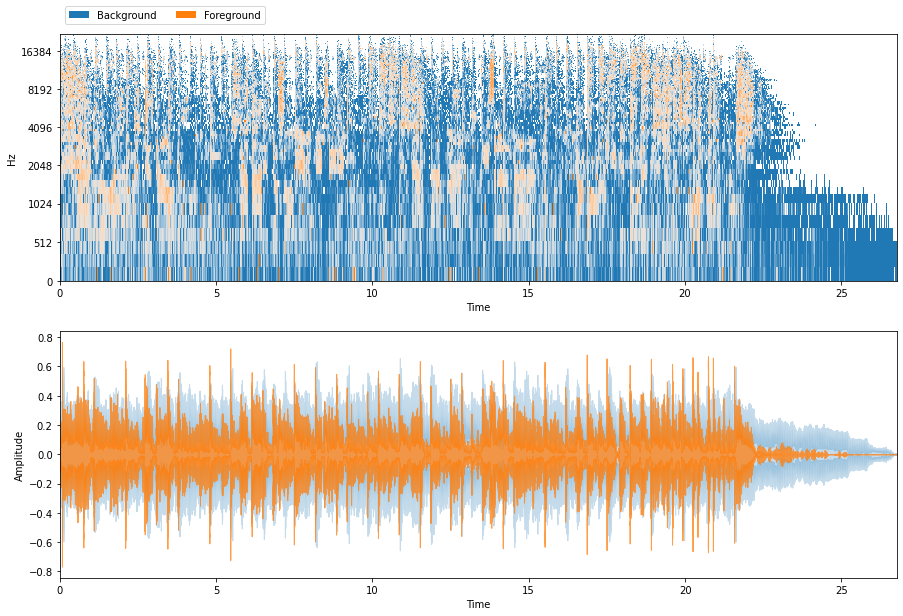


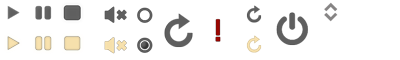
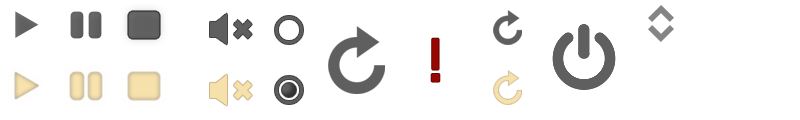
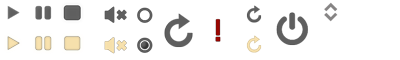

In [36]:
plt.figure(figsize=(15, 10))
plt.subplot(211)
nussl.utils.visualize_sources_as_masks({
    'Background': ft2d_bg, 'Foreground': ft2d_fg},
    y_axis='mel', db_cutoff=-60, alpha_amount=2.0)


plt.subplot(212)
nussl.utils.visualize_sources_as_waveform({
    'Background': ft2d_bg, 'Foreground': ft2d_fg},
    show_legend=False)
plt.show()
nussl.play_utils.multitrack(ft2d())